## PyTorch로 경사하강법(Gradient Descent) 구현

기본 개념은 함수의 기울기(경사)를 구하여 기울기가 낮은 쪽으로 계속 이동시켜서 극값에 이를 때까지 반복시키는 것입니다.

**비용 함수 (Cost Function 혹은 Loss Function)를 최소화**하기 위해 반복해서 파라미터를 업데이트 해 나가는 방식입니다.

경사하강법에 대한 상세한 설명은 아래 링크를 참고해 주시기 바랍니다.

- [경사하강법 구현](https://teddylee777.github.io/scikit-learn/gradient-descent)
- [경사하강법 기본 개념(YouTube)](https://www.youtube.com/watch?v=GEdLNvPIbiM)

In [185]:
# 모듈 import 
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

## 샘플 데이터셋 생성

- `y = 0.3x + 0.5`의 선형회귀 식을 추종하는 샘플 데이터셋을 생성합니다.
- 경사하강법 알고리즘으로 `w=0.3`, `b=0.5`를 추종하는 결과를 도출하도록 하겠습니다.

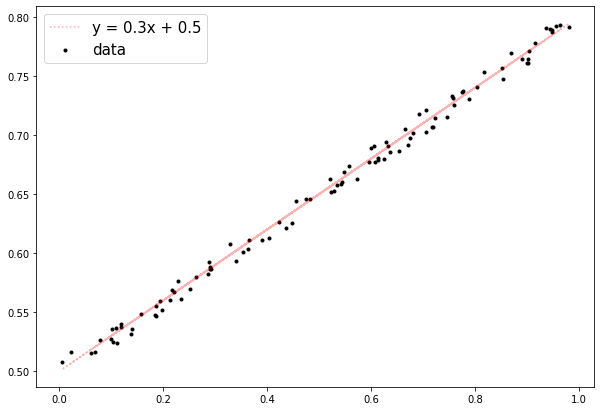

w: 0.3, b: 0.5


In [194]:
def make_linear(w=0.5, b=0.8, size=50, noise=1.0):
    x = np.random.rand(size)
    y = w * x + b
    noise = np.random.uniform(-abs(noise), abs(noise), size=y.shape)
    yy = y + noise
    plt.figure(figsize=(10, 7))
    plt.plot(x, y, color='r', label=f'y = {w}x + {b}', linestyle=':', alpha=0.3)
    plt.scatter(x, yy, color='black', label='data', marker='.')
    plt.legend(fontsize=15)
    plt.show()
    print(f'w: {w}, b: {b}')
    return x, yy

x, y = make_linear(w=0.3, b=0.5, size=100, noise=0.01)

샘플 데이터셋인 `x`와 `y`를 `torch.as_tensor()`로 텐서(Tensor)로 변환합니다.

In [200]:
# 샘플 데이터셋을 텐서(tensor)로 변환
x = torch.as_tensor(x)
y = torch.as_tensor(y)

랜덤한 `w`, `b`를 생성합니다. `torch.rand(1)`은 `torch.Size([1])`을 가지는 normal 분포의 랜덤 텐서를 생성합니다.

In [216]:
# random 한 값으로 w, b를 초기화 합니다.
w = torch.rand(1)
b = torch.rand(1)

print(w.shape, b.shape)

# requires_grad = True로 설정된 텐서에 대해서만 미분을 계산합니다.
w.requires_grad = True
b.requires_grad = True

torch.Size([1]) torch.Size([1])


다음은 가설함수(Hypothesis Function), 여기서는 Affine Function을 정의합니다.

In [217]:
# Hypothesis Function 정의
y_hat = w * x + b

`y_hat`과 `y`의 손실(Loss)을 계산합니다. 여기서 손실함수는 **Mean Squared Error** 함수를 사용합니다.

$\Large Loss = \sum_{i=1}^{N}(\hat{y}_i-y_i)^2$

In [218]:
# 손실함수 정의
loss = ((y_hat - y)**2).mean()

`loss.backward()` 호출시 미분 가능한 텐서(Tensor)에 대하여 미분을 계산합니다.

In [219]:
# 미분 계산 (Back Propagation)
loss.backward()

`w`와 `b`의 미분 값을 확인합니다.

In [220]:
# 계산된 미분 값 확인
w.grad, b.grad

(tensor([-0.6570]), tensor([-1.1999]))

## 경사하강법 구현

- 최대 500번의 iteration(epoch) 동안 반복하여 w, b의 미분을 업데이트 하면서, 최소의 손실(loss)에 도달하는 `w`, `b`를 산출합니다.
- `learning_rate`는 임의의 값으로 초기화 하였으며, `0.1`로 설정하였습니다.

하이퍼파라미터(hyper-parameter) 정의

In [179]:
# 최대 반복 횟수 정의
num_epoch = 500

# 학습율 (learning_rate)
learning_rate = 0.1

In [229]:
# loss, w, b 기록하기 위한 list 정의
losses = []
ws = []
bs = []

# random 한 값으로 w, b를 초기화 합니다.
w = torch.rand(1)
b = torch.rand(1)

# 미분 값을 구하기 위하여 requires_grad는 True로 설정
w.requires_grad = True
b.requires_grad = True

for epoch in range(num_epoch):
    # Affine Function
    y_hat = x * w + b

    # 손실(loss) 계산
    loss = ((y_hat - y)**2).mean()
    
    # 손실이 0.00005보다 작으면 break 합니다.
    if loss < 0.00005:
        break

    # w, b의 미분 값인 grad 확인시 다음 미분 계산 값은 None이 return 됩니다.
    # 이러한 현상을 방지하기 위하여 retain_grad()를 loss.backward() 이전에 호출해 줍니다.
    w.retain_grad()
    b.retain_grad()
    
    # 미분 계산
    loss.backward()
    
    # 경사하강법 계산 및 적용
    # w에 learning_rate * (그라디언트 w) 를 차감합니다.
    w = w - learning_rate * w.grad
    # b에 learning_rate * (그라디언트 b) 를 차감합니다.
    b = b - learning_rate * b.grad
    
    # 계산된 loss, w, b를 저장합니다.
    losses.append(loss.item())
    ws.append(w.item())
    bs.append(b.item())

    if epoch % 5 == 0:
        print("{0:03d} w = {1:.5f}, b = {2:.5f} loss = {3:.5f}".format(epoch, w.item(), b.item(), loss.item()))
    
print("----" * 15)
print("{0:03d} w = {1:.1f}, b = {2:.1f} loss = {3:.5f}".format(epoch, w.item(), b.item(), loss.item()))

000 w = -0.01099, b = 0.89355 loss = 0.10401
005 w = -0.05946, b = 0.74602 loss = 0.01675
010 w = -0.05314, b = 0.70280 loss = 0.01087
015 w = -0.03533, b = 0.68401 loss = 0.00940
020 w = -0.01588, b = 0.67136 loss = 0.00829
025 w = 0.00302, b = 0.66061 loss = 0.00733
030 w = 0.02093, b = 0.65077 loss = 0.00648
035 w = 0.03779, b = 0.64158 loss = 0.00573
040 w = 0.05365, b = 0.63295 loss = 0.00506
045 w = 0.06856, b = 0.62485 loss = 0.00448
050 w = 0.08257, b = 0.61724 loss = 0.00396
055 w = 0.09573, b = 0.61008 loss = 0.00350
060 w = 0.10811, b = 0.60336 loss = 0.00310
065 w = 0.11974, b = 0.59704 loss = 0.00274
070 w = 0.13067, b = 0.59110 loss = 0.00242
075 w = 0.14094, b = 0.58551 loss = 0.00215
080 w = 0.15060, b = 0.58027 loss = 0.00190
085 w = 0.15967, b = 0.57534 loss = 0.00168
090 w = 0.16820, b = 0.57070 loss = 0.00149
095 w = 0.17622, b = 0.56634 loss = 0.00132
100 w = 0.18375, b = 0.56225 loss = 0.00117
105 w = 0.19083, b = 0.55840 loss = 0.00104
110 w = 0.19749, b = 0.5547

## 결과 시각화

- `loss`는 epoch이 늘어남에 따라 감소합니다.
-  epoch 초기에는 급격히 감소하다가, 점차 완만하게 감소함을 확인할 수 있는데, 이는 초기에는 큰 미분 값이 업데이트 되지만, 점차 계산된 미분 값이 작아지게되고 결국 업데이트가 작게 일어나면서 손실은 완만하게 감소하였습니다.
- `w`, `b`도 초기값은 `0.3`, `0.5`와 다소 먼 값이 설정되었지만, 점차 정답을 찾아가게 됩니다.

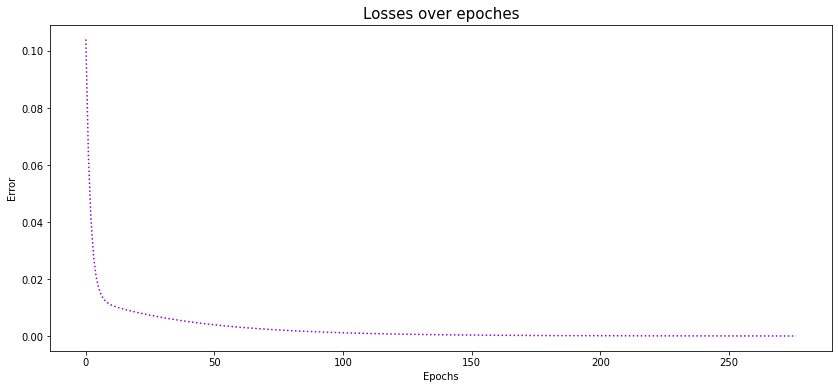

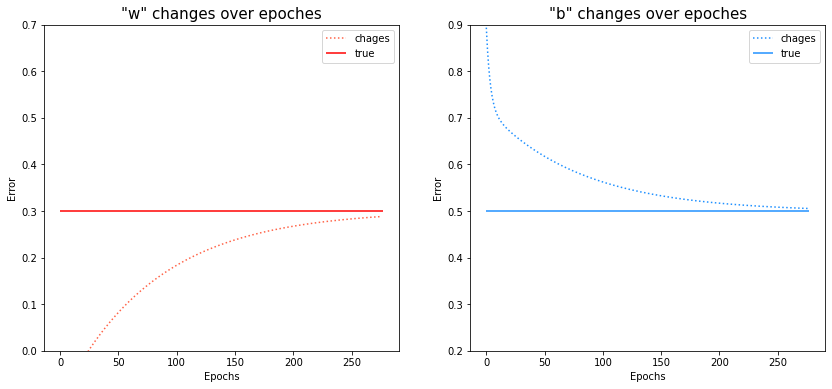

In [231]:
# 전체 loss 에 대한 변화량 시각화
plt.figure(figsize=(14, 6))
plt.plot(losses, c='darkviolet', linestyle=':')

plt.title('Losses over epoches', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

# w, b에 대한 변화량 시각화
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

axes[0].plot(ws, c='tomato', linestyle=':', label='chages')
axes[0].hlines(y=0.3, xmin=0, xmax=len(ws), color='r', label='true')
axes[0].set_ylim(0, 0.7)
axes[0].set_title('"w" changes over epoches', fontsize=15)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Error')
axes[0].legend()

axes[1].plot(bs, c='dodgerblue', linestyle=':', label='chages')
axes[1].hlines(y=0.5, xmin=0, xmax=len(ws), color='dodgerblue', label='true')
axes[1].set_ylim(0.2, 0.9)
axes[1].set_title('"b" changes over epoches', fontsize=15)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Error')
axes[1].legend()

plt.show()